## Data Preprocessing

In [1]:
# Import the libraries
import os
import numpy as np 
import pandas as pd 
import c_visuals as vs
import matplotlib.pyplot as plt
import seaborn as sns  
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# Change working directory
os.chdir('C:/Users/User/Desktop/Data&Code/Insurance/Insurance_2019')

In [5]:
# Import Data
Insurance = pd.read_excel('INSURANCE_2019_20200326_V1.xlsx')

# Create Product_sub_Category 
Insurance['Product_sub_Category'] = Insurance['Insure_Company'] + '_' + Insurance['Product_Category']

# Group by created variables
bins = [0, 20, 40, 50, 60, 70, 120]
labels = ['0-19', '20-39', '40-49', '50-59', '60-69','70+']
Insurance_flat = Insurance.groupby(['Customer_ID','Product_Category'])['Buy_Amount'].sum().unstack()
Insurance_flat['Buy_Amount'] = Insurance.groupby(['Customer_ID'])['Buy_Amount'].sum()
Insurance_flat['Age'] = Insurance.groupby(['Customer_ID'])['Age'].first()
Insurance_flat.fillna(value=1, inplace=True)

# Age bin
Insurance_flat['Age_bins'] = pd.cut(x=Insurance_flat['Age'], bins = bins, labels = labels,include_lowest = True)
Insurance_flat.head()

Product_Category,Others,保險附約,年金保險,意外傷害,終身壽險,終身醫療,萬能壽險,長照險,Buy_Amount,Age,Age_bins
Customer_ID,,,,,,,,,,,
A120675488,1.0,1.0,615700.0,1.0,1.0,1.0,1.0,1.0,615700,48,40-49
A120778788,1.0,1.0,1.0,1.0,1.0,1.0,1.0,29070.0,29070,50,40-49
A120844152,1.0,12813.0,1.0,1.0,4204.0,1.0,1.0,1.0,17017,46,40-49
A121706428,1.0,37.0,1.0,1.0,1.0,1.0,1.0,1.0,37,48,40-49
A122767372,1.0,1.0,1.0,1.0,1.0,1.0,1.0,52328.0,52328,46,40-49


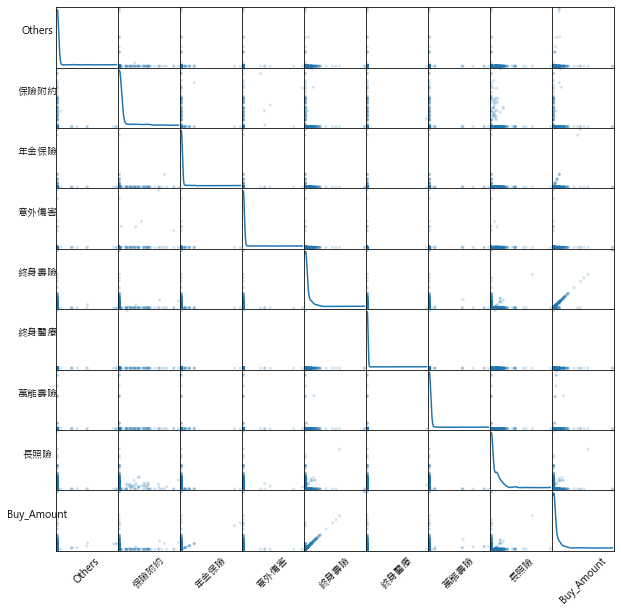

In [6]:
# Scatter_matrix plot of all features
Insurance_flat_numeric = Insurance_flat.iloc[:,:-2]
sm = pd.plotting.scatter_matrix(Insurance_flat_numeric, alpha=0.2, figsize=(10, 10), diagonal = 'kde')

# Change label rotation
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

# May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-0.3,0.5) for s in sm.reshape(-1)]

# Hide all ticks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

# plt.show()
plt.savefig('Insurance_2019_Var.png')

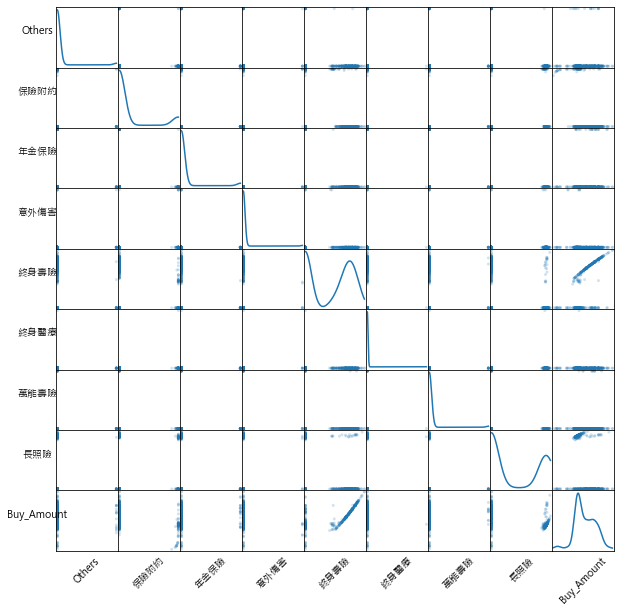

In [7]:
# Scale the data using the Box Cox method
from sklearn.preprocessing import PowerTransformer

bc = PowerTransformer(method='box-cox')
Insurance_scaled_features = bc.fit_transform(Insurance_flat_numeric.values)
Insurance_scaled_features_df = pd.DataFrame(Insurance_scaled_features, index=Insurance_flat_numeric.index,\
                                         columns=Insurance_flat_numeric.columns)
sm = pd.plotting.scatter_matrix(Insurance_scaled_features_df, alpha=0.2, figsize=(10, 10), diagonal = 'kde')

# Change label rotation
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

# May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-0.3,0.5) for s in sm.reshape(-1)]

# Hide all ticks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

# plt.show()
plt.savefig('Insurance_2019_Var_Norm.png')

In [8]:
# Age df
Age_df = Insurance_flat.groupby('Age_bins').size().to_frame(name = 'Size')
Age_df['Buy_Amount'] = Insurance_flat.groupby('Age_bins')['Buy_Amount'].sum()
Age_df

,Size,Buy_Amount
Age_bins,,
0-19,58,14235424
20-39,158,36295097
40-49,150,36834466
50-59,122,51301377
60-69,67,59494620
70+,9,6432637


Text(0.5, 1.0, 'Insurance_2019_Age_distribution')

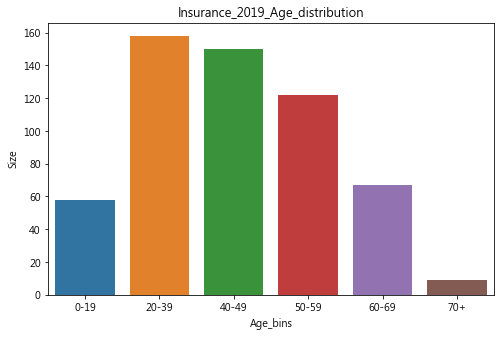

In [11]:
# Plot age distribution
plt.figure(figsize = (8,5))
sns.barplot(x = Age_df.index,y = Age_df['Size'])
plt.title('Insurance_2019_Age_distribution')

Text(0.5, 1.0, 'Insurance_2019_Age_buy_amount')

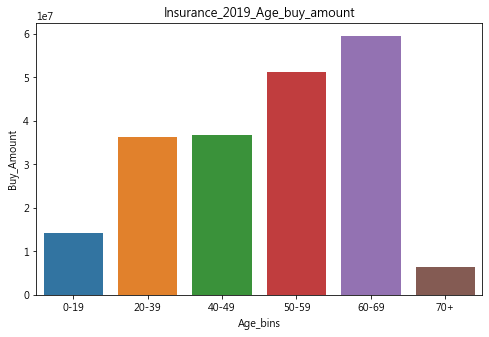

In [12]:
# Age_bin vs. Buy_amount barplot
plt.figure(figsize = (8,5))
sns.barplot(x = Age_df.index, y = Age_df.Buy_Amount)
plt.title('Insurance_2019_Age_buy_amount')

Text(0.5, 1.0, 'Insurance_2019_Age_Average_buy_amount')

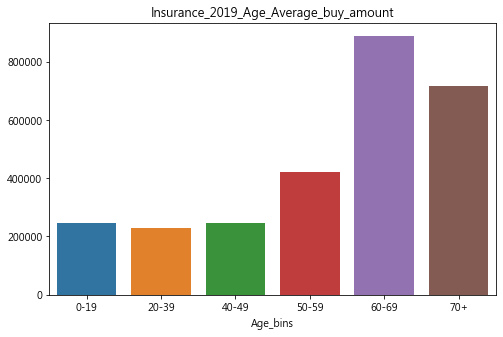

In [13]:
# Age_bin vs. Buy_amount barplot
plt.figure(figsize = (8,5))
sns.barplot(x = Age_df.index, y = Age_df.Buy_Amount / Age_df.Size)
plt.title('Insurance_2019_Age_Average_buy_amount')

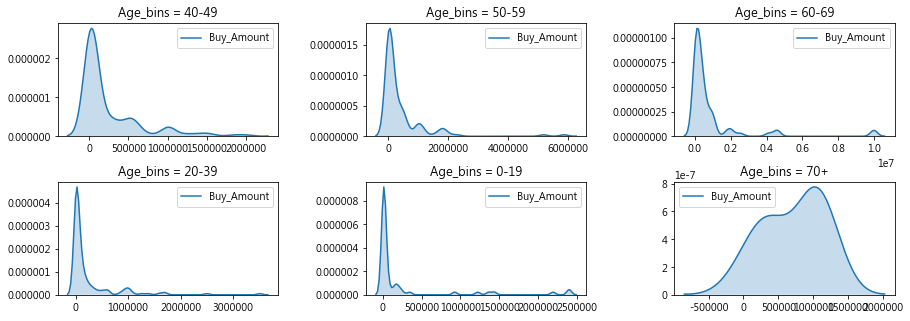

In [14]:
# Age bin kde plot
fig , ax = plt.subplots(figsize = (15,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i,j in enumerate(Insurance_flat.Age_bins.unique()):
    plt.subplot(2, 3, i+1)
    filter_ = Insurance_flat['Age_bins'] == j
    sns.kdeplot(Insurance_flat.loc[filter_].Buy_Amount, shade=True)
    plt.title("Age_bins = {}" .format(j))

## Outlier Detection

In [15]:
# Outlier detection
import xlsxwriter

# Create a new df with the descriptive features
Insurance_feat_w_prop_df = Insurance_flat_numeric
# Insurance_feat_w_prop_df['Customer_Name'] = Insurance.groupby(['Customer_ID'])['Customer_Name'].first()
Insurance_feat_w_prop_df['Age'] = Insurance.groupby(['Customer_ID'])['Age'].first()
Insurance_feat_w_prop_df['Gender'] = Insurance.groupby(['Customer_ID'])['Gender'].first()
Insurance_feat_w_prop_df['Constellation'] = Insurance.groupby(['Customer_ID'])['Constellation'].first()
Insurance_feat_w_prop_df['Buy_Amount'] = Insurance.groupby(['Customer_ID'])['Buy_Amount'].sum()
Insurance_feat_w_prop_df['Com_ID'] = Insurance.groupby(['Customer_ID'])['Com_ID'].first()
Insurance_feat_w_prop_df['Sales_ID'] = Insurance.groupby(['Customer_ID'])['Com_ID'].first()
Insurance_feat_w_prop_df['Sales_Name'] = Insurance.groupby(['Customer_ID'])['Com_ID'].first()

feature_outliers = []
writer = pd.ExcelWriter('Insurance_2019_Outliers_sheets.xlsx', engine='xlsxwriter')

for feature in Insurance_scaled_features_df.keys():
    Q1 = np.percentile(Insurance_scaled_features_df[feature], 25)
    Q3 = np.percentile(Insurance_scaled_features_df[feature], 75)
    step = 1.5*(Q3 - Q1)
    Outlier_Index = ~((Insurance_scaled_features_df[feature] >= Q1 - step)&\
                       (Insurance_scaled_features_df[feature] <= Q3 + step))
    Insurance_feat_w_prop_df.loc[Insurance_scaled_features_df.loc[Outlier_Index].index,:].groupby(['Customer_ID']).first()\
    .to_excel(writer, sheet_name = feature)
    feature_outliers.append(Insurance_feat_w_prop_df.loc[Insurance_scaled_features_df.loc[Outlier_Index].index,:])
writer.save()

# Flatten list of outliers
outliers_flattened = []

for i, j in enumerate(feature_outliers):
    outliers_flattened.append(feature_outliers[i].index)
flat_list = [item for sublist in outliers_flattened for item in sublist]

# Count the number of features for which a given observation is considered an outlier
from collections import Counter
outlier_count = Counter(flat_list)
outliers = [observation for observation in outlier_count.elements() if outlier_count[observation] >= 3]
Insurance_feat_w_prop_df.loc[Insurance_scaled_features_df.loc[outliers].index,:].groupby(['Customer_ID']).first()\
.to_csv('Insurance_2019_Outliers.csv', encoding='utf_8_sig')

## PCA vs. SVD

,Explained Var,Others,保險附約,年金保險,意外傷害,終身壽險,終身醫療,萬能壽險,長照險,Buy_Amount
Dim 1,0.2619,0.0211,0.2916,-0.0249,0.1294,-0.5809,0.0726,-0.0465,0.4919,-0.5571
Dim 2,0.1349,0.2774,0.5443,-0.2692,0.6023,0.2401,0.1517,-0.1484,-0.2962,-0.0324
Dim 3,0.1245,0.4991,-0.0396,0.6956,0.2079,-0.2908,-0.1470,0.2269,-0.2462,0.0632
Dim 4,0.1150,-0.4476,0.2503,0.5564,-0.0646,0.0471,0.5422,-0.3369,-0.1140,0.0231
Dim 5,0.1130,-0.1623,0.1228,-0.1151,-0.0091,-0.0524,0.4446,0.8582,-0.0878,0.0246
Dim 6,0.1078,0.6153,-0.2102,-0.1649,-0.3073,-0.0587,0.6304,-0.2030,0.0827,0.0826
Dim 7,0.0879,-0.1537,-0.5298,0.0190,0.6860,-0.0303,0.2233,-0.0330,0.3402,0.2392
Dim 8,0.0482,0.0951,0.4631,0.0737,-0.0893,-0.0011,-0.1059,0.0509,0.5368,0.6791
Dim 9,0.0067,0.1888,-0.0085,0.2954,-0.0053,0.7149,0.0061,0.1715,0.4222,-0.3979


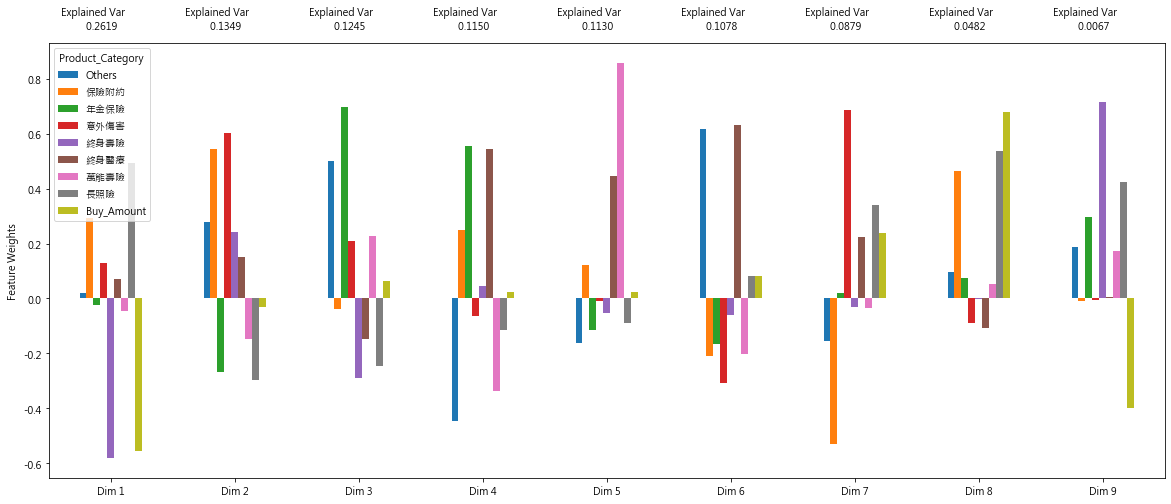

In [16]:
# PCA
from sklearn.decomposition import PCA

# Apply PCA by fitting the good data with the same number of dimensions as features
num_features = Insurance_scaled_features_df.shape[1]
pca = PCA(n_components = num_features, random_state = 0)
pca = pca.fit(Insurance_scaled_features_df)

# Transform log_samples using the PCA fit above

# Generate PCA results plot
vs.pca_results(Insurance_scaled_features_df, pca)

,Explained Var,Others,保險附約,年金保險,意外傷害,終身壽險,終身醫療,萬能壽險,長照險,Buy_Amount
Dim 1,0.2619,0.0211,0.2916,-0.0249,0.1294,-0.5809,0.0726,-0.0465,0.4919,-0.5571
Dim 2,0.1349,0.2774,0.5443,-0.2692,0.6023,0.2401,0.1517,-0.1484,-0.2962,-0.0324
Dim 3,0.1245,0.4991,-0.0396,0.6956,0.2079,-0.2908,-0.1470,0.2269,-0.2462,0.0632
Dim 4,0.1150,-0.4476,0.2503,0.5564,-0.0646,0.0471,0.5422,-0.3369,-0.1140,0.0231
Dim 5,0.1130,-0.1623,0.1228,-0.1151,-0.0091,-0.0524,0.4446,0.8582,-0.0878,0.0246
Dim 6,0.1078,0.6153,-0.2102,-0.1649,-0.3073,-0.0587,0.6304,-0.2030,0.0827,0.0826
Dim 7,0.0879,-0.1537,-0.5298,0.0190,0.6860,-0.0303,0.2233,-0.0330,0.3402,0.2392
Dim 8,0.0482,0.0951,0.4631,0.0737,-0.0893,-0.0011,-0.1059,0.0509,0.5368,0.6791


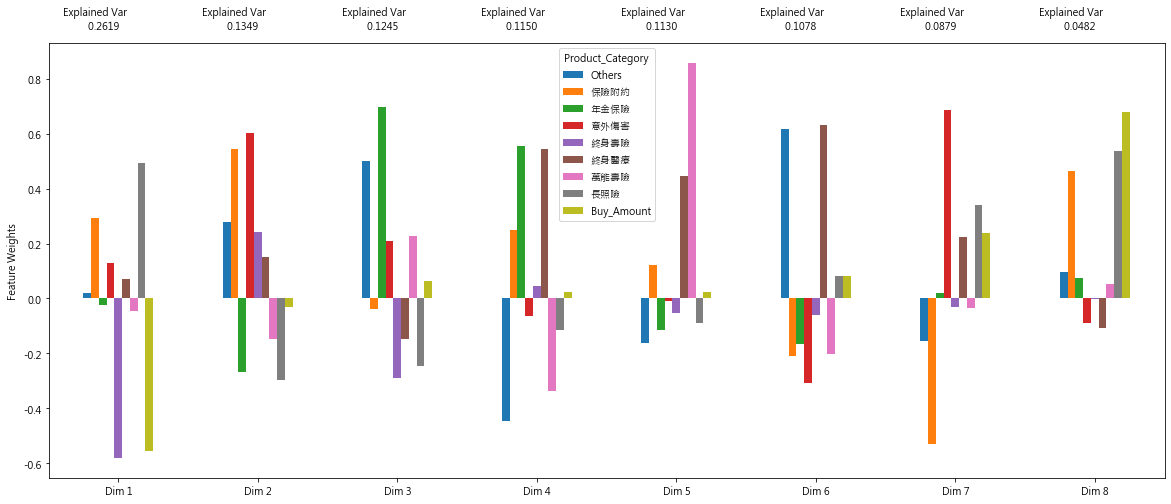

In [18]:
# SVD
from sklearn.decomposition import TruncatedSVD

# Apply PCA by fitting the good data with the same number of dimensions as features
num_features = Insurance_scaled_features_df.shape[1] - 1
svd = TruncatedSVD(n_components = num_features, random_state = 0)
svd = svd.fit(Insurance_scaled_features_df)

# Transform log_samples using the PCA fit above

# Generate PCA results plot
vs.pca_results(Insurance_scaled_features_df, svd)

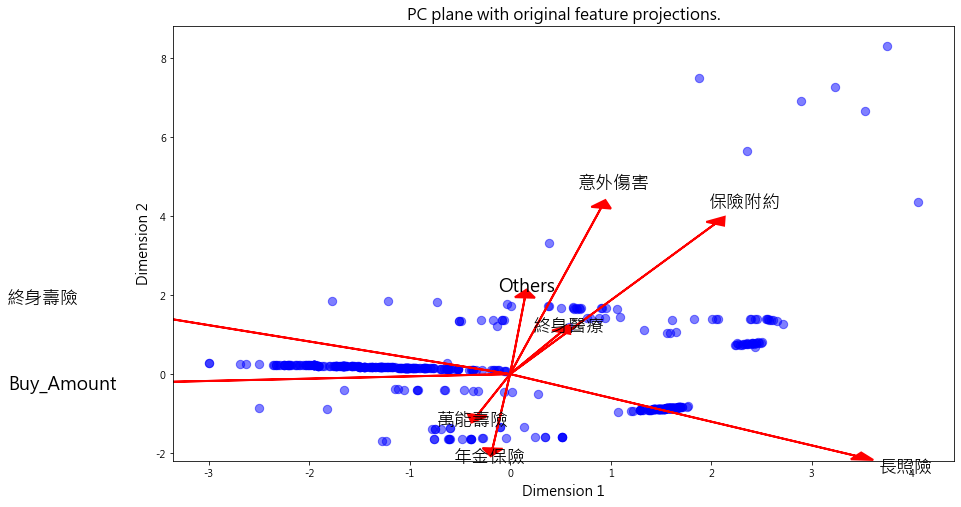

In [19]:
# Apply PCA by fitting data with only 2 Dimensions
pca = PCA(n_components = 2, random_state = 0)
pca = pca.fit(Insurance_scaled_features_df)

# Transform the good data using the PCA fit above
reduced_data = pca.transform(Insurance_scaled_features_df)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

vs.biplot(Insurance_scaled_features_df ,reduced_data, pca)

## K means Clustering

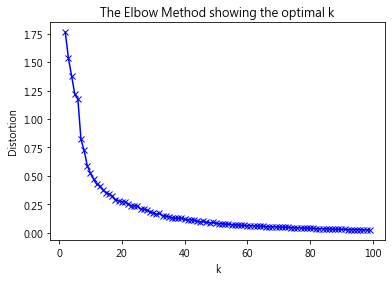

In [20]:
# clustering dataset
# determine k using elbow method

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

# k means determine k
distortions = []
K = range(2,100)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(Insurance_scaled_features_df)
    distortions.append(sum(np.min(cdist(Insurance_scaled_features_df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / \
                       Insurance_scaled_features_df.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

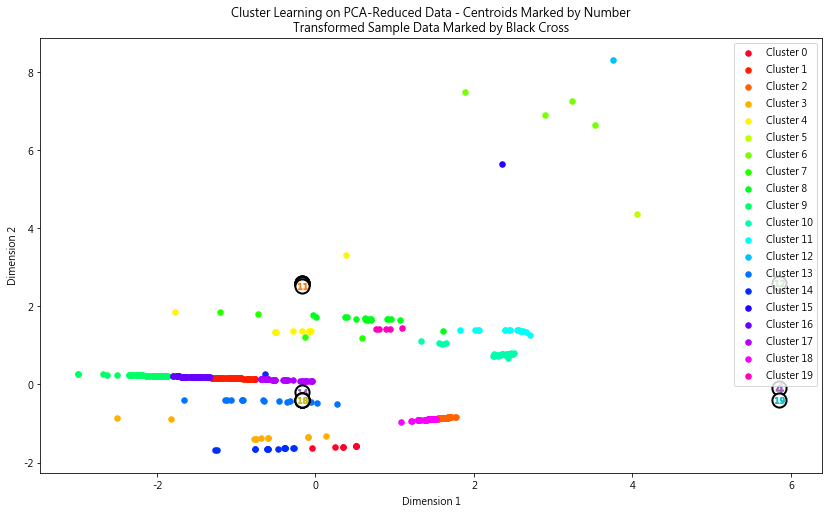

In [21]:
# Clustering(Elbow_method)
optimized_kmeans = KMeans(n_clusters = 20, random_state = 0).fit(Insurance_scaled_features_df)
kmeans_preds = optimized_kmeans.predict(Insurance_scaled_features_df)
kmeans_centers = optimized_kmeans.cluster_centers_
vs.cluster_results(reduced_data, kmeans_preds, kmeans_centers)

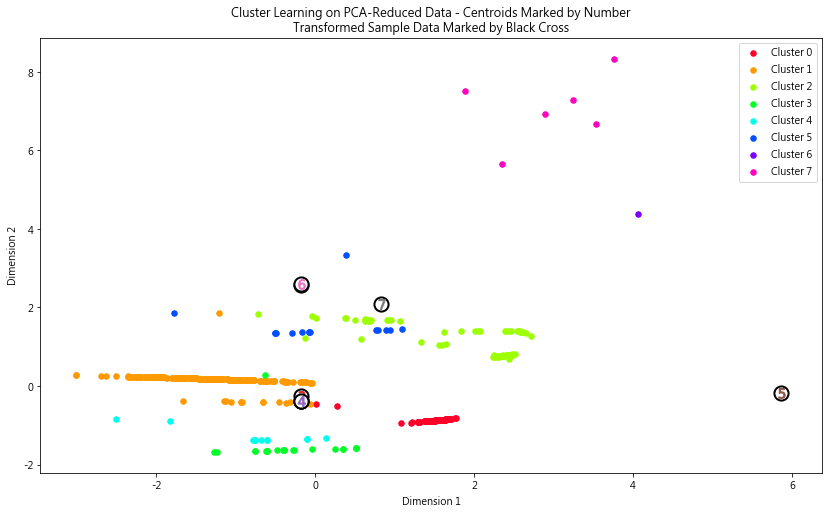

In [22]:
# Clustering(silhouette_score method)
# Clustering(silhouette_score method)
# silhouette_score method
num_clusters = np.arange(2,30)
kmeans_results = {}
for size in num_clusters:
    kmeans = KMeans(n_clusters = size).fit(Insurance_scaled_features_df)
    preds = kmeans.predict(Insurance_scaled_features_df)
    kmeans_results[size] = metrics.silhouette_score(Insurance_scaled_features_df, preds)
    
best_size = max(kmeans_results, key = kmeans_results.get)

optimized_kmeans = KMeans(n_clusters = best_size, random_state = 0).fit(Insurance_scaled_features_df)
kmeans_preds = optimized_kmeans.predict(Insurance_scaled_features_df)
kmeans_centers = optimized_kmeans.cluster_centers_
vs.cluster_results(reduced_data, kmeans_preds, kmeans_centers)

For n_clusters = 2 The average silhouette_score is : 0.45433142104409685
For n_clusters = 3 The average silhouette_score is : 0.5133019189140127
For n_clusters = 4 The average silhouette_score is : 0.5557730186783286
For n_clusters = 5 The average silhouette_score is : 0.5928765165959117
For n_clusters = 6 The average silhouette_score is : 0.6001330471598829
For n_clusters = 7 The average silhouette_score is : 0.6231445339259873
For n_clusters = 8 The average silhouette_score is : 0.7120029299188126
For n_clusters = 9 The average silhouette_score is : 0.6392008221558783
For n_clusters = 10 The average silhouette_score is : 0.6561215586089524
For n_clusters = 11 The average silhouette_score is : 0.6866840251348767
For n_clusters = 12 The average silhouette_score is : 0.7035789385511023
For n_clusters = 13 The average silhouette_score is : 0.7029890416764458
For n_clusters = 14 The average silhouette_score is : 0.6866916947425231
For n_clusters = 15 The average silhouette_score is : 0.67

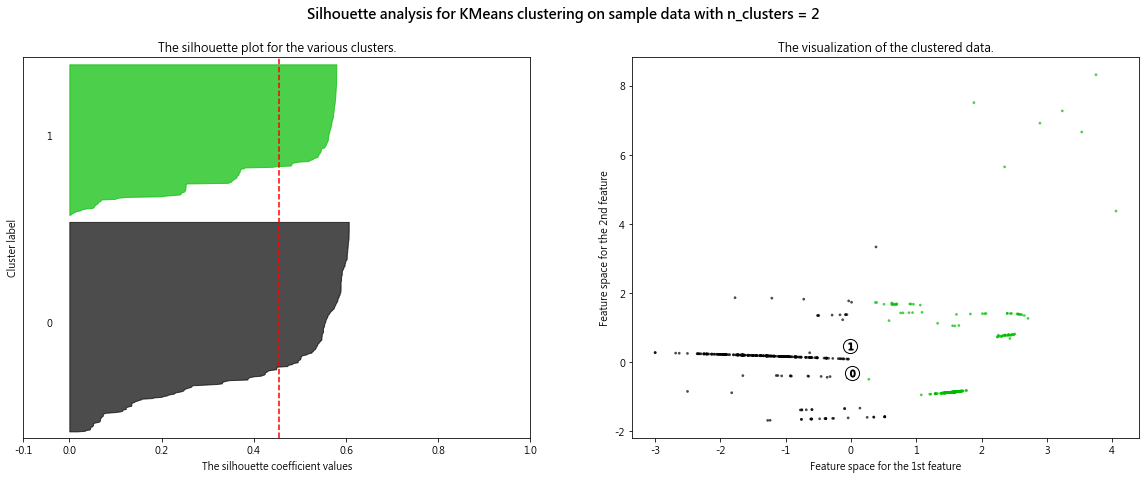

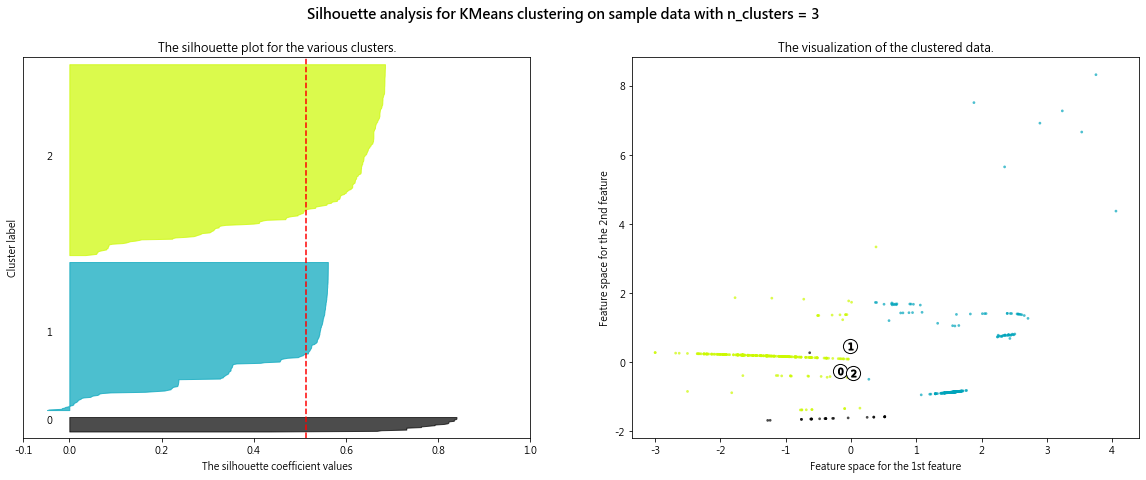

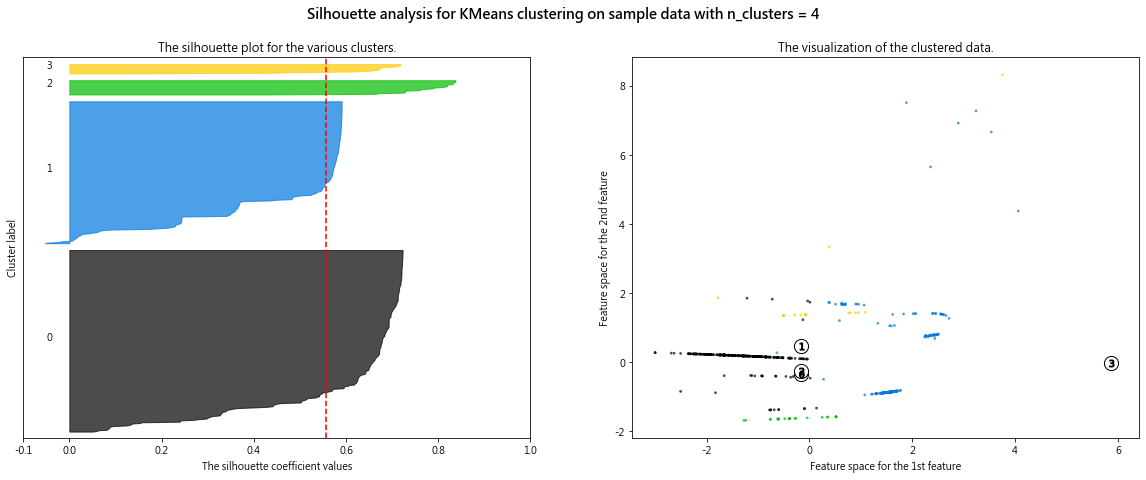

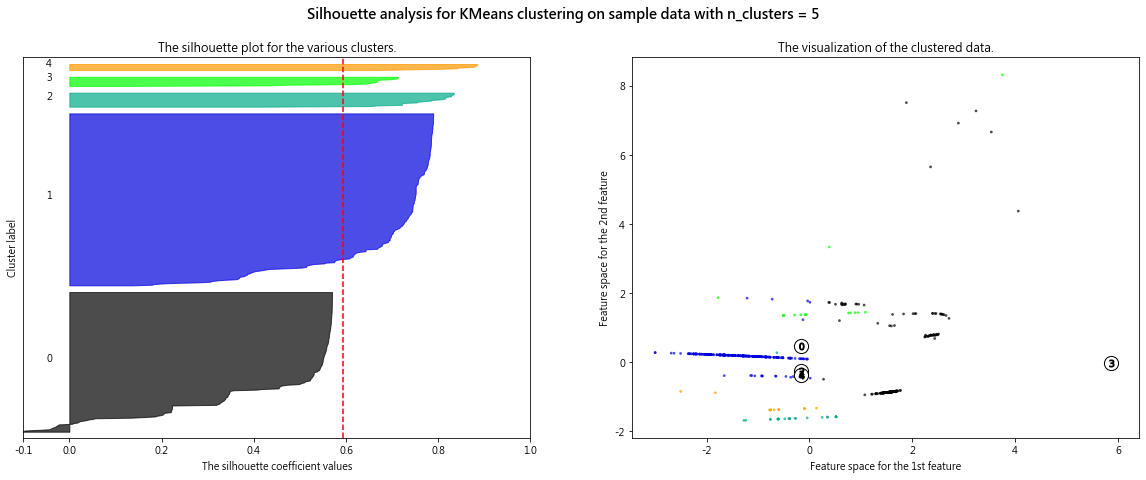

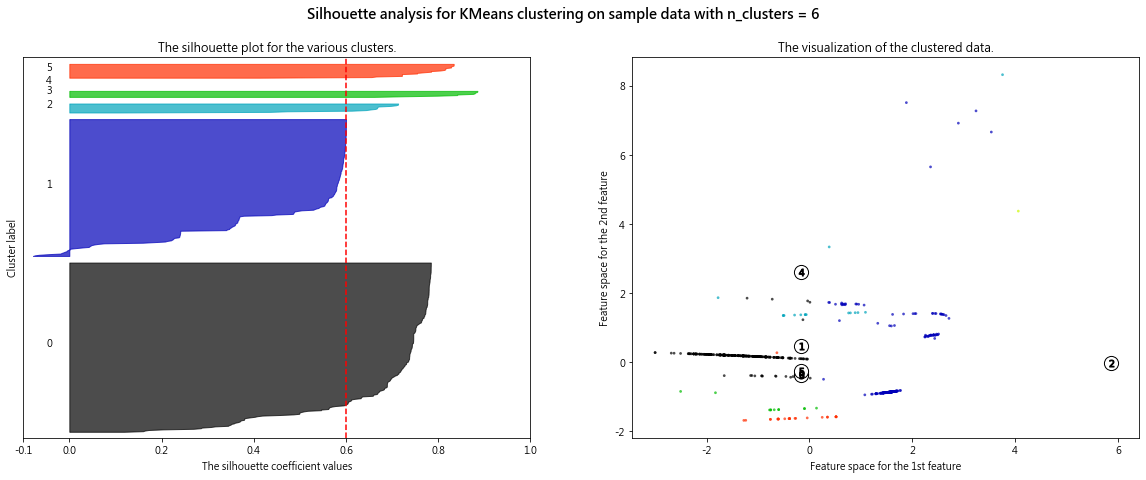

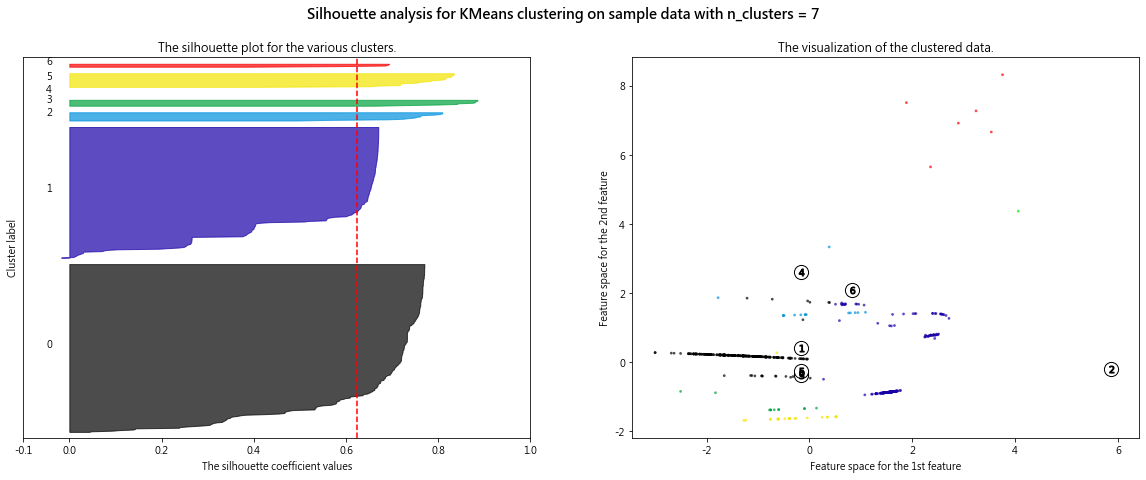

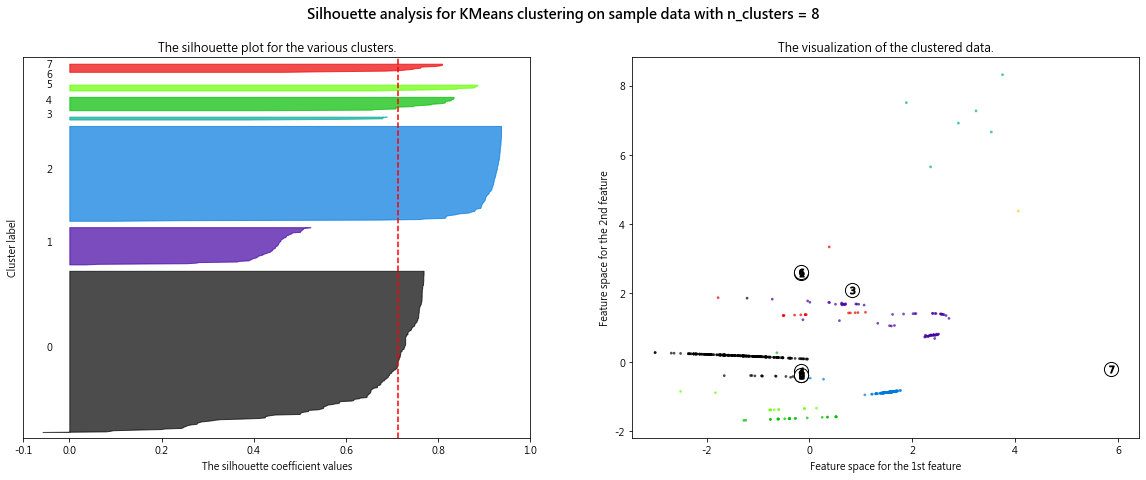

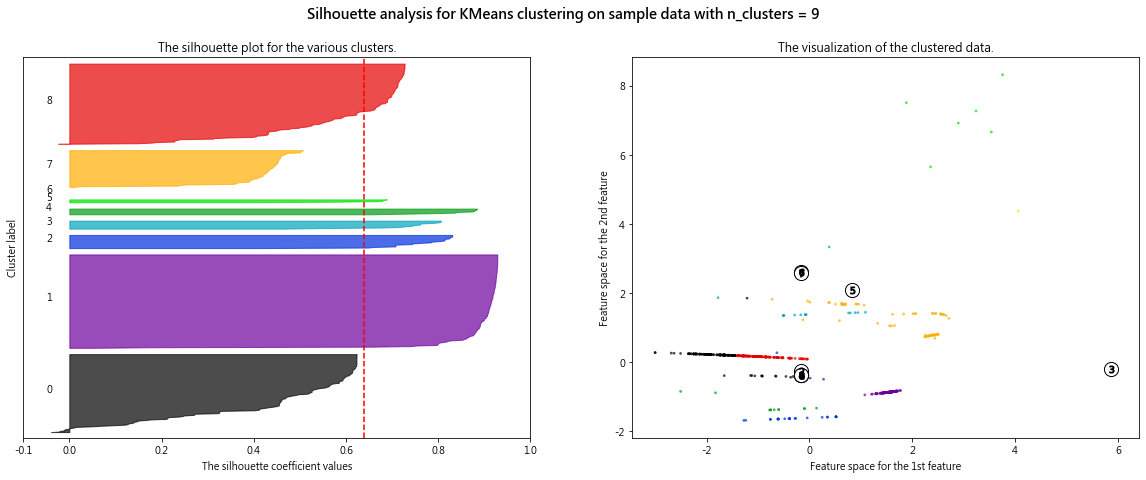

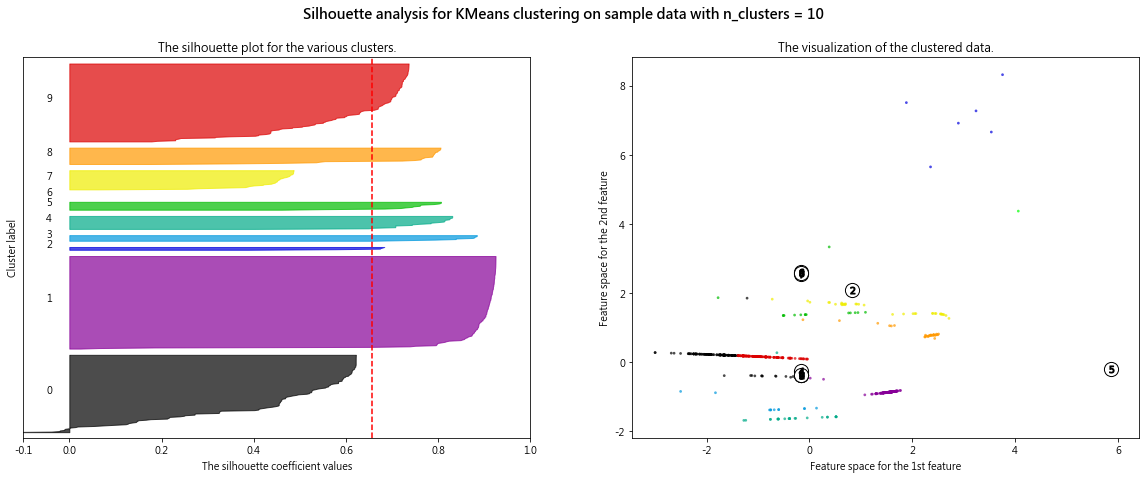

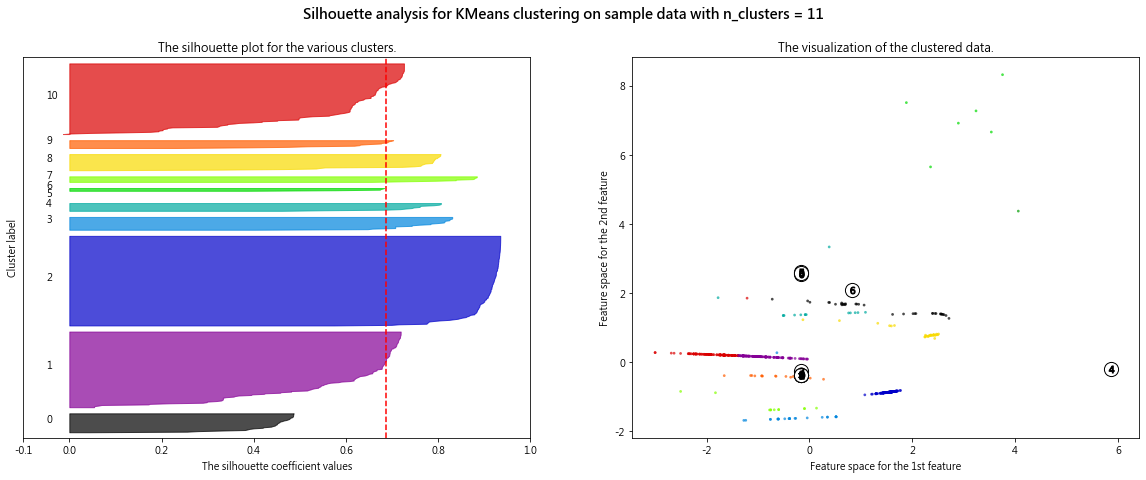

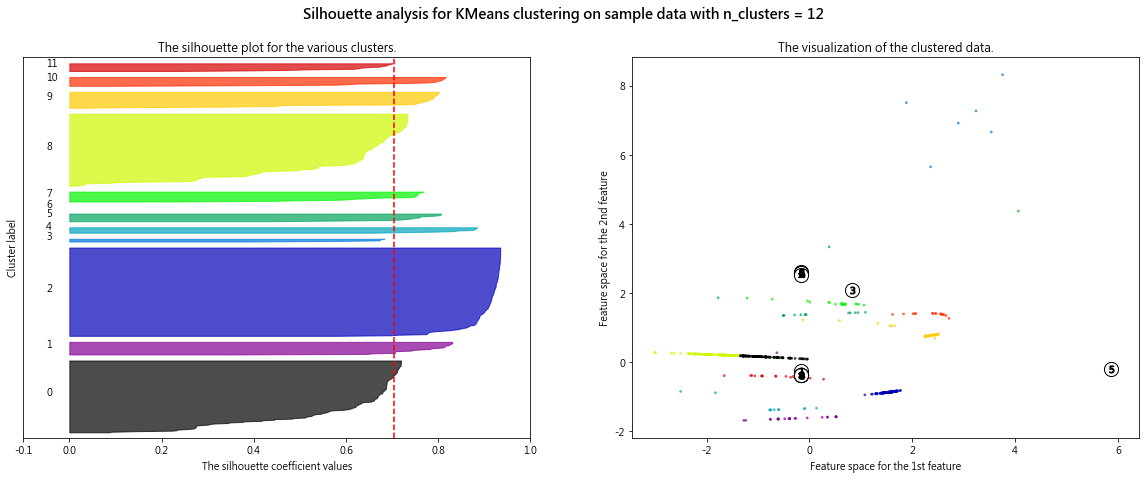

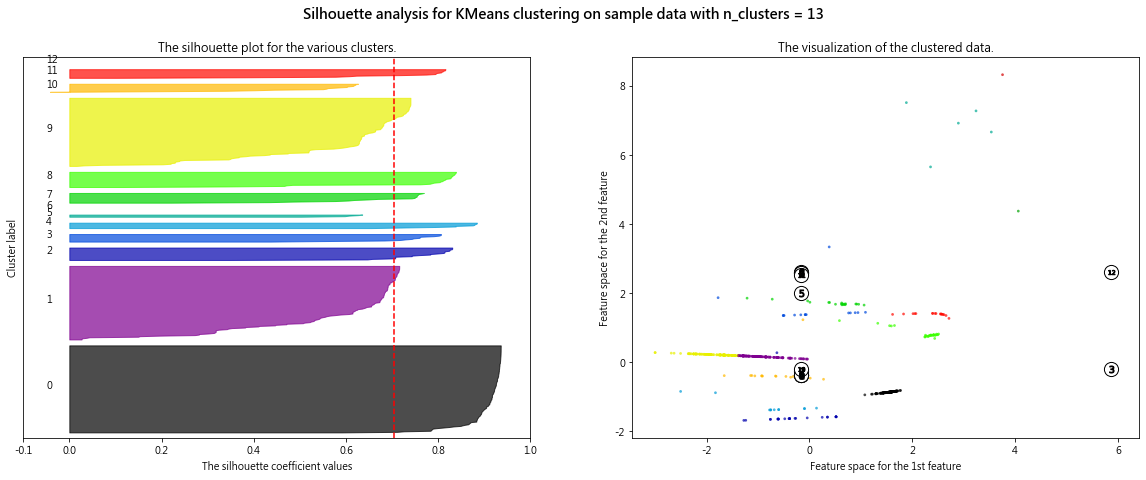

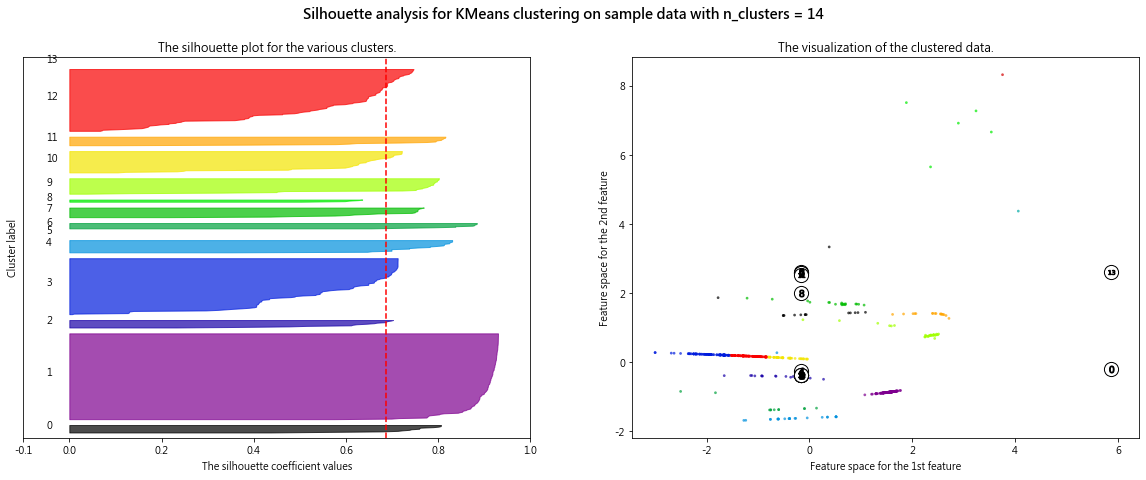

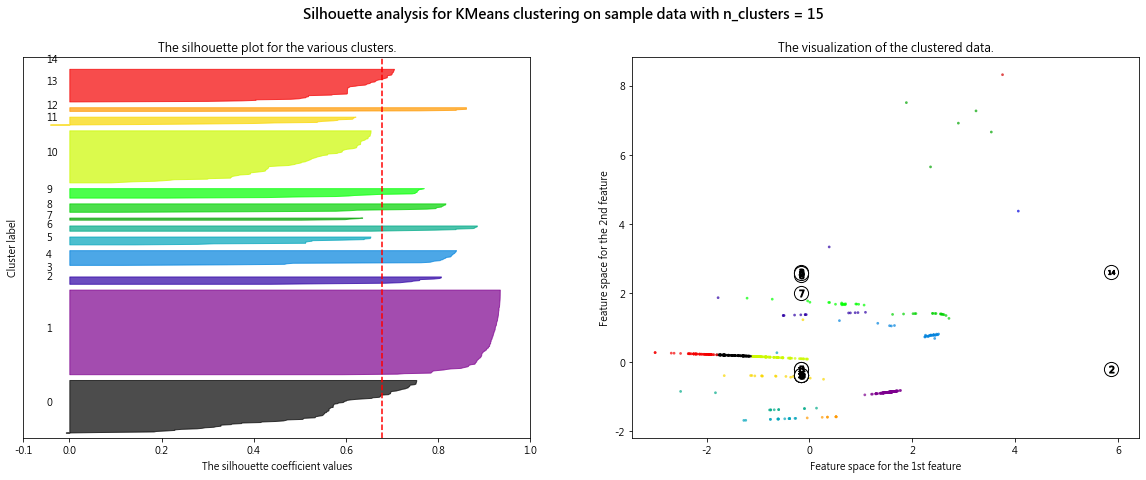

In [23]:
# silhouette_score plot
vs.Silhouette_score(r = 16, df = Insurance_scaled_features_df, reduced_df = reduced_data)
plt.savefig('Insurance_2019'+ '_Silhouette_score' + '.png')

## K Prototype Clustering

In [24]:
Insurance_scaledfeat_w_prop_df = Insurance_scaled_features_df
Insurance_scaledfeat_w_prop_df['Age_bins'] = Insurance_flat['Age_bins']
Insurance_scaledfeat_w_prop_df['Gender'] = Insurance.groupby(['Customer_ID'])['Gender'].first()
Insurance_scaledfeat_w_prop_df['Constellation'] = Insurance.groupby(['Customer_ID'])['Constellation'].first()
Insurance_scaledfeat_w_prop_df['Com_ID'] = Insurance.groupby(['Customer_ID'])['Com_ID'].first()
Insurance_scaledfeat_w_prop_df['Sales_ID'] = Insurance.groupby(['Customer_ID'])['Sales_ID'].first()
Insurance_scaledfeat_w_prop_df.head()

Product_Category,Others,保險附約,年金保險,意外傷害,終身壽險,終身醫療,萬能壽險,長照險,Buy_Amount,Age_bins,Gender,Constellation,Com_ID,Sales_ID
Customer_ID,,,,,,,,,,,,,,
A120675488,-0.170872,-0.388542,4.743417,-0.103695,-1.078266,-0.042145,-0.141037,-0.772744,1.086489,40-49,MALE,金牛座,585J,03138
A120778788,-0.170872,-0.388542,-0.210819,-0.103695,-1.078266,-0.042145,-0.141037,1.353035,-0.458291,40-49,MALE,白羊座,585Z,92139
A120844152,-0.170872,2.593162,-0.210819,-0.103695,0.230707,-0.042145,-0.141037,-0.772744,-0.697712,40-49,MALE,白羊座,5854,08005
A121706428,-0.170872,2.494637,-0.210819,-0.103695,-1.078266,-0.042145,-0.141037,-0.772744,-2.898894,40-49,MALE,摩羯座,585b,87123
A122767372,-0.170872,-0.388542,-0.210819,-0.103695,-1.078266,-0.042145,-0.141037,1.397230,-0.185241,40-49,MALE,雙魚座,585Z,93337


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 102, ncost: 2945.5550066638743
Run: 1, iteration: 2/100, moves: 12, ncost: 2937.535064797685
Run: 1, iteration: 3/100, moves: 0, ncost: 2937.535064797685
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 52, ncost: 2622.9982825584907
Run: 2, iteration: 2/100, moves: 14, ncost: 2578.417902365361
Run: 2, iteration: 3/100, moves: 2, ncost: 2577.5843684429215
Run: 2, iteration: 4/100, moves: 1, ncost: 2576.8432515189893
Run: 2, iteration: 5/100, moves: 0, ncost: 2576.8432515189893
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 118, ncost: 2022.0108831038708
Run: 3, iteration: 2/100, moves: 20, ncost: 2018.1310684916339
Run: 3, iteration: 3/

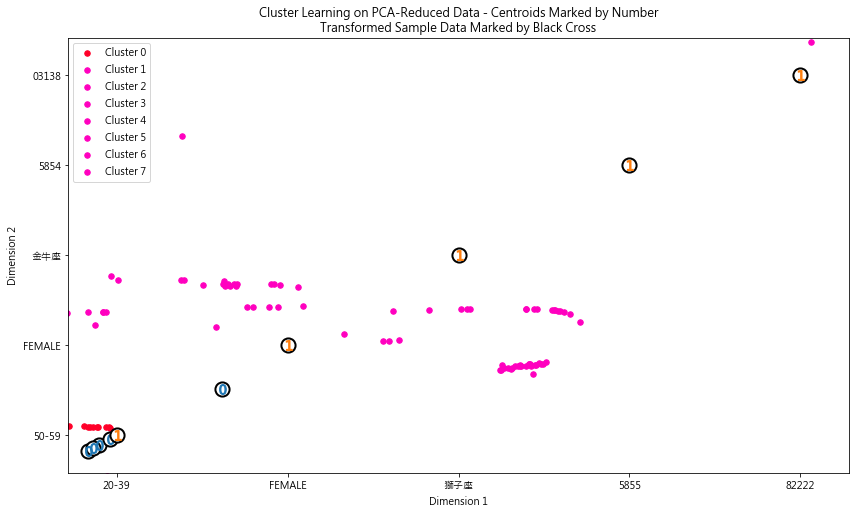

In [27]:
from kmodes.kprototypes import KPrototypes

# K Prototype Clustering
kproto = KPrototypes(n_clusters = best_size, init='Cao', verbose=2)
kproto_preds = kproto.fit_predict(Insurance_scaledfeat_w_prop_df, categorical=[9, 10, 11, 12, 13])
kproto_centers = kproto.cluster_centroids_
vs.cluster_results(reduced_data, kproto_preds, kproto_centers)

## Data Recovery

In [29]:
## K means
# Inverse transform the box-cox centers
true_centers = bc.inverse_transform(kmeans_centers)
true_centers[np.isnan(true_centers)] = 1

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(kmeans_centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = Insurance_scaled_features_df.iloc[:,:9].keys())
true_centers.index = segments
display(true_centers)

# Segment mean
Insurance_flat['Label'] = optimized_kmeans.labels_
display(round(Insurance_flat.groupby('Label').mean()))

C:\Users\User\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2909: RuntimeWarning: divide by zero encountered in power
  x_inv = (x * lmbda + 1) ** (1 / lmbda)


Product_Category,Others,保險附約,年金保險,意外傷害,終身壽險,終身醫療,萬能壽險,長照險,Buy_Amount
Segment 0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15726.0,16531.0
Segment 1,1.0,1.0,1.0,1.0,246003.0,1.0,1.0,1.0,260704.0
Segment 2,1.0,170.0,1.0,1.0,34.0,1.0,1.0,15.0,6728.0
Segment 3,1.0,1.0,23309.0,1.0,1.0,1.0,1.0,1.0,212899.0
Segment 4,1.0,1.0,1.0,1.0,14.0,1.0,5624.0,1.0,251865.0
Segment 5,5285.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,117062.0
Segment 6,1.0,3358.0,1.0,1.0,1.0,inf,1.0,8910.0,20284.0
Segment 7,1.0,7.0,1.0,13.0,14.0,1.0,1.0,19.0,8789.0


Product_Category,Others,保險附約,年金保險,意外傷害,終身壽險,終身醫療,萬能壽險,長照險,Buy_Amount,Age
Label,,,,,,,,,,
0,1.0,1.0,1.0,1.0,725.0,1.0,1.0,19016.0,19740.0,40.0
1,1.0,62.0,1.0,1.0,616300.0,1.0,1.0,1063.0,617423.0,46.0
2,1.0,6887.0,1.0,1.0,30786.0,1.0,1.0,4555.0,42226.0,37.0
3,1.0,791.0,683844.0,1.0,138.0,1.0,1.0,1.0,684771.0,50.0
4,1.0,1.0,1.0,1.0,156835.0,1.0,274254.0,1.0,431088.0,40.0
5,341796.0,440.0,1.0,1.0,36602.0,1.0,1.0,1.0,378836.0,48.0
6,1.0,3358.0,1.0,1.0,1.0,8016.0,1.0,8910.0,20284.0,37.0
7,21.0,9384.0,1.0,839.0,632.0,1.0,1.0,3916.0,14788.0,26.0


In [30]:
## K mode
# Inverse transform the box-cox centers
true_centers = bc.inverse_transform(kproto_centers[0])
true_centers[np.isnan(true_centers)] = 1

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(kmeans_centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = Insurance_scaled_features_df.iloc[:,:9].keys())
true_centers.index = segments
display(true_centers)

# Segment mean
Insurance_flat['Label'] = kproto.labels_
display(round(Insurance_flat.groupby('Label').mean()))

C:\Users\User\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2909: RuntimeWarning: divide by zero encountered in power
  x_inv = (x * lmbda + 1) ** (1 / lmbda)


Product_Category,Others,保險附約,年金保險,意外傷害,終身壽險,終身醫療,萬能壽險,長照險,Buy_Amount
Segment 0,1.0,1.0,1.0,1.0,245821.0,1.0,1.0,1.0,260596.0
Segment 1,1.0,1.0,23309.0,1.0,1.0,1.0,1.0,1.0,212899.0
Segment 2,1.0,1.0,1.0,1.0,14.0,1.0,5624.0,1.0,251865.0
Segment 3,5285.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,117062.0
Segment 4,1.0,7.0,1.0,13.0,14.0,1.0,1.0,19.0,8789.0
Segment 5,1.0,3358.0,1.0,1.0,1.0,inf,1.0,8910.0,20284.0
Segment 6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15686.0,16545.0
Segment 7,1.0,170.0,1.0,1.0,34.0,1.0,1.0,15.0,6728.0


Product_Category,Others,保險附約,年金保險,意外傷害,終身壽險,終身醫療,萬能壽險,長照險,Buy_Amount,Age
Label,,,,,,,,,,
0,1.0,62.0,1.0,1.0,616229.0,1.0,1.0,1086.0,617375.0,46.0
1,1.0,791.0,683844.0,1.0,138.0,1.0,1.0,1.0,684771.0,50.0
2,1.0,1.0,1.0,1.0,156835.0,1.0,274254.0,1.0,431088.0,40.0
3,341796.0,440.0,1.0,1.0,36602.0,1.0,1.0,1.0,378836.0,48.0
4,21.0,9384.0,1.0,839.0,632.0,1.0,1.0,3916.0,14788.0,26.0
5,1.0,3358.0,1.0,1.0,1.0,8016.0,1.0,8910.0,20284.0,37.0
6,1.0,1.0,1.0,1.0,844.0,1.0,1.0,18978.0,19821.0,40.0
7,1.0,6887.0,1.0,1.0,30786.0,1.0,1.0,4555.0,42226.0,37.0


In [31]:
# Save Customer list 
Insurance_flat['Gender']= Insurance.groupby(['Customer_ID'])['Gender'].first()
Insurance_flat.loc[:,['Age', 'Gender', 'Label']].to_excel('Insurance_2018_Customer_list.xlsx')

## ANOVA test (k means only)

In [32]:
# ANOVA test
import scipy.stats as ss
Insurance_flat_t = Insurance_flat.drop(['Gender','Age_bins'], axis = 1)
for Variable in Insurance_flat_t.keys():
    samples = [val[1] for val in Insurance_flat_t.groupby('Label')[Variable]]
    f_val, p_val = ss.f_oneway(*samples)
    print('Variable: {}, F value: {:.3f}, p value: {:.3f}'.format(Variable, f_val, p_val))

Variable: Others, F value: 68.825, p value: 0.000
Variable: 保險附約, F value: 73.157, p value: 0.000
Variable: 年金保險, F value: 26.809, p value: 0.000
Variable: 意外傷害, F value: 328.637, p value: 0.000
Variable: 終身壽險, F value: 11.880, p value: 0.000
Variable: 終身醫療, F value: inf, p value: 0.000
Variable: 萬能壽險, F value: 158.836, p value: 0.000
Variable: 長照險, F value: 58.264, p value: 0.000
Variable: Buy_Amount, F value: 9.965, p value: 0.000
Variable: Age, F value: 6.215, p value: 0.000
Variable: Label, F value: 445714040408510848.000, p value: 0.000


C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:3349: RuntimeWarning: divide by zero encountered in double_scalars
  f = msb / msw


In [33]:
# T test with onw population mean
mean_list = list(Insurance_flat.mean())
Segment = []
Var = []
T_test = []

for index_1, label_name in enumerate(Insurance_flat_t.groupby('Label')):
    for index_2,col in enumerate(label_name[1]):
        t, p_val = ss.ttest_1samp(label_name[1][col],mean_list[index_2])
        Segment.append(index_1)
        Var.append(col)
        T_test.append((round(t,2),round(p_val,2)))
# T_test_df        
T_test_df = pd.DataFrame()
T_test_df['Segment'] = Segment
T_test_df['Var'] = Var
T_test_df['T_test(t,p_val)'] = T_test

# Export
T_test_df.groupby(['Var','Segment']).first().drop('Label').unstack().T.to_excel('Insurance_2019_T_test.xlsx')

C:\Users\User\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\User\anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
